# 🌳 Predicción NBA 2026 — Modelos Tree-Based (Random Forest / Gradient Boosting)

En este notebook entrenamos modelos de **Machine Learning clásicos basados en árboles**
utilizando el dataset enriquecido con features (notebook 02).

**Objetivos:**

1. Definir un conjunto de *features* de entrada (`X`) y varios *targets* (`y`):
   - `HOME_WIN` (clasificación, probabilidad de victoria local).
   - `MARGIN_HOME` (regresión del margen de puntos).
   - `TOTAL_POINTS` (regresión de puntos totales).
2. Realizar un **split temporal** train/test (respetando el orden de los partidos).
3. Entrenar modelos:
   - `RandomForestClassifier` para `HOME_WIN`.
   - `RandomForestRegressor` para `MARGIN_HOME` y `TOTAL_POINTS`.
4. Evaluar las métricas:
   - Clasificación: accuracy, matriz de confusión.
   - Regresión: MAE, RMSE, R².


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

pd.set_option("display.max_columns", 60)

data_path = "../data/processed/games_2025_26_features.csv"
df = pd.read_csv(data_path, parse_dates=["GAME_DATE"])

df.head()


,GAME_ID,GAME_DATE,HOME_TEAM_ID,HOME_TEAM_NAME,HOME_TEAM_ABBR,HOME_PTS,AWAY_TEAM_ID,AWAY_TEAM_NAME,AWAY_TEAM_ABBR,AWAY_PTS,MARGIN_HOME,HOME_WIN,TOTAL_POINTS,HOME_PF_AVG_LAST5,HOME_PA_AVG_LAST5,HOME_WIN_RATE_LAST5,HOME_MARGIN_AVG_LAST5,HOME_STREAK,HOME_REST_DAYS,AWAY_PF_AVG_LAST5,AWAY_PA_AVG_LAST5,AWAY_WIN_RATE_LAST5,AWAY_MARGIN_AVG_LAST5,AWAY_STREAK,AWAY_REST_DAYS,REST_ADVANTAGE
0,22500001,2025-10-21,1610612760,Oklahoma City Thunder,OKC,125,1610612745,Houston Rockets,HOU,124,1,1,249,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,22500002,2025-10-21,1610612747,Los Angeles Lakers,LAL,109,1610612744,Golden State Warriors,GSW,119,-10,0,228,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,22500003,2025-10-22,1610612752,New York Knicks,NYK,119,1610612739,Cleveland Cavaliers,CLE,111,8,1,230,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,22500004,2025-10-22,1610612742,Dallas Mavericks,DAL,92,1610612759,San Antonio Spurs,SAS,125,-33,0,217,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,22500080,2025-10-22,1610612766,Charlotte Hornets,CHA,136,1610612751,Brooklyn Nets,BKN,117,19,1,253,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


## 1. Selección de features y targets

Utilizaremos como features numéricas:

- Stats recientes del local y visitante:
  - `HOME_PF_AVG_LAST5`, `HOME_PA_AVG_LAST5`, `HOME_WIN_RATE_LAST5`, `HOME_MARGIN_AVG_LAST5`
  - `AWAY_PF_AVG_LAST5`, `AWAY_PA_AVG_LAST5`, `AWAY_WIN_RATE_LAST5`, `AWAY_MARGIN_AVG_LAST5`
- Rachas:
  - `HOME_STREAK`, `AWAY_STREAK`
- Días de descanso y ventaja:
  - `HOME_REST_DAYS`, `AWAY_REST_DAYS`, `REST_ADVANTAGE`

Targets a trabajar:
- Clasificación: `HOME_WIN`
- Regresión 1: `MARGIN_HOME`
- Regresión 2: `TOTAL_POINTS`


In [2]:
feature_cols = [
    "HOME_PF_AVG_LAST5", "HOME_PA_AVG_LAST5",
    "HOME_WIN_RATE_LAST5", "HOME_MARGIN_AVG_LAST5",
    "AWAY_PF_AVG_LAST5", "AWAY_PA_AVG_LAST5",
    "AWAY_WIN_RATE_LAST5", "AWAY_MARGIN_AVG_LAST5",
    "HOME_STREAK", "AWAY_STREAK",
    "HOME_REST_DAYS", "AWAY_REST_DAYS",
    "REST_ADVANTAGE",
]

target_clf = "HOME_WIN"
target_margin = "MARGIN_HOME"
target_total = "TOTAL_POINTS"

df[feature_cols + [target_clf, target_margin, target_total]].head()


,HOME_PF_AVG_LAST5,HOME_PA_AVG_LAST5,HOME_WIN_RATE_LAST5,HOME_MARGIN_AVG_LAST5,AWAY_PF_AVG_LAST5,AWAY_PA_AVG_LAST5,AWAY_WIN_RATE_LAST5,AWAY_MARGIN_AVG_LAST5,HOME_STREAK,AWAY_STREAK,HOME_REST_DAYS,AWAY_REST_DAYS,REST_ADVANTAGE,HOME_WIN,MARGIN_HOME,TOTAL_POINTS
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,1,1,249
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,-10,228
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,1,8,230
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,-33,217
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,1,19,253


## 2. Split train/test temporal

Para evitar fuga de información temporal, utilizamos:
- Las primeras ~80% de filas (en orden de `GAME_DATE`) como **train**.
- El 20% restante como **test**.

No usamos `shuffle=True`.


In [3]:
df = df.sort_values("GAME_DATE").reset_index(drop=True)

X = df[feature_cols].copy()
y_clf = df[target_clf]
y_margin = df[target_margin]
y_total = df[target_total]

test_size = 0.2
split_index = int(len(df) * (1 - test_size))

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_clf_train = y_clf.iloc[:split_index]
y_clf_test = y_clf.iloc[split_index:]

y_margin_train = y_margin.iloc[:split_index]
y_margin_test = y_margin.iloc[split_index:]

y_total_train = y_total.iloc[:split_index]
y_total_test = y_total.iloc[split_index:]

len(X_train), len(X_test)


(9, 3)

## 3. Funciones auxiliares para evaluar modelos


In [4]:
def eval_classification(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"Accuracy: {acc:.3f}")
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()


def eval_regression(y_true, y_pred, name="Modelo"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")


## 4. Modelo 1 — Clasificación (`HOME_WIN`) con RandomForestClassifier


Accuracy: 1.000


D:\Miniconda\envs\nba2026\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


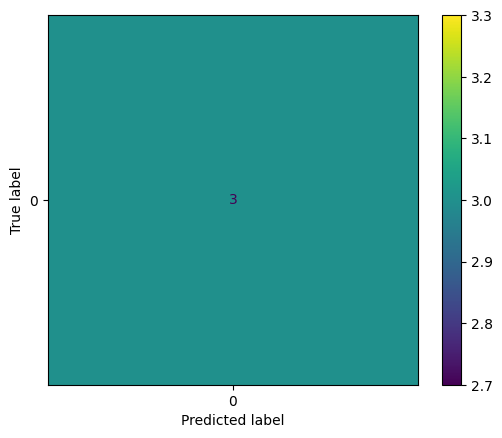

In [5]:
clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)

clf.fit(X_train, y_clf_train)

y_clf_pred = clf.predict(X_test)

eval_classification(y_clf_test, y_clf_pred)
